# DEEE725 Speech Signal Processing Lab
### 2023 Spring, Kyungpook National University 
### Instructor: Gil-Jin Jang

# Project 1 Isolated digit recognition in noisy environments

- Assigned: 2023/04/21
- Due: 2023/05/04
- Required dataset: 
    1. [training data](lab05.pdf)
    1. [validation data](lab05.md)
    1. [test data](lab05.md)

----
# import packages, define analysis parameters and draw parameters, audio file preparation, etc.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib
import librosa
from matplotlib import pyplot as plt
import librosa.display

from scipy import signal
from scipy.fft import fftshift

import IPython # display wav files

신호 분석과 스펙트럼을 그리기 위한 다음의 parameter 들을 정의한다.
입력 파일의 sampling frequency 를 이용하여 shift size 를 sample 수로 정의하기 위해 사용된다.
- `Ts`: shift length in seconds, default 0.01 sec = 10 ms. 
- `Tf`: frame length in seconds, default 0.02 sec = 20 ms

In [2]:
# parameters for signal analysis
# Fs = 16000  native sampling frequency (wav file 에 정의된 것) 을 사용하면 필요 없음
Ts = 0.01   # 10 ms shift size
Tf = 0.02   # 20 ms frame size

spectrum 을 그리기 위한 parameters.
- `cmap_plot`: colormap. default value is `pyplot.cm.bone_r` (최소값 흰색, 최대값 검은색 의 gray scale) 

In [3]:
# parameters for drawing
#cmap_plot = plt.cm.bone # default colormap for spectrogram, gray
cmap_plot = plt.cm.bone_r # default colormap for spectrogram, gray, reversed
#cmap_plot = plt.cm.plasma 
#cmap_plot = plt.cm.inferno
#FIG_SIZE = (15,10)   # obsolete
FIG_SIZE = (8,3)

---
### 이전 lab 들에서 정의한 함수들

In [4]:
# draw spectrogram
from gjdrawspectrogram3 import drawspectrogram3

# linear phase FIR filter design from magnitudes of the frequency components
from gjfiroverlapadd import getLPHFIRFFT

# trapezoidal overlap add for FIR filtering
from gjfiroverlapadd import firoverlapadd

# save audio in wav format
import gjwavfile as wav

---
### load speech and noise

오디오 파일이 16 kHz, mono 인지 확인 

In [5]:
x = np.zeros(10)
print(len(x), x.ndim)
x = np.zeros((10,2))
print(len(x), x.ndim)

10 1
10 2


오디오 파일들의 경로 정의

In [6]:
# add '/' if path is not a null string
def addpath(path, file):
    if len(path) == 0: 
        return file
    else:
        return path + '/' + file

In [7]:
def check_audio_file(file, defFs, checkMono):
    signal, Fs = librosa.load(file, sr=None, mono=False)
    if defFs != Fs:
        print('sampling rate mismatch, %d != %d for file %s'%(defFs, Fs, file))
        return False
    elif checkMono == True:
        if signal.ndim != 1:
            print('not mono file %s, shape='%(file), signal.shape)
            return False
        return True
    elif size(signal) <= 0:
        print('wrong audio file %s, shape='%(file), signal.shape)
    else:
        return True

def convert_audio_file(file, forceFs, forceMono):
    signal, Fs = librosa.load(file, sr=None, mono=False)
    changed = False
    if forceFs != Fs:
        print('sampling rate mismatch, %d != %d for file %s'%(forceFs, Fs, file))
        signal, Fs = librosa.load(file, sr=forceFs, mono=False)
        changed = True
    elif forceMono == True:
        if signal.ndim != 1:
            print('not mono file %s, shape='%(file), signal.shape)
            signal, Fs = librosa.load(file, sr=forceFs, mono=True)
            changed = True
    elif size(signal) <= 0:
        print('wrong audio file %s, shape='%(file), signal.shape)
        return False
    if changed == True:
        wav.writewav(file, Fs, signal, maxval=1.0)
        print('updating', file)
    return changed

In [8]:
trainroot = 'segmented-train'

labels_train = {'11jeonghy', 
                'Dandyst', 
                'InkooJeon',
                'shin3875',
                'YouYeNa',
                'son',
               }

# check
Fs = 16000
con = []
ind = []
cnt = 0
for subname in labels_train:
    line = []
    num_files = 0
    num_false_files = 0
    for w in range(10):
        for trial in range(10):
            basename = '%d/kdigits%d-%d.wav'%(w,trial,w)
            file = addpath(trainroot, addpath(subname, basename))
            num_files += 1
            if check_audio_file(file, Fs, True) == False:
                num_false_files += 1
    line.append(num_false_files)
    line.append(num_files)
    con.append(line)
    ind.append(subname)
col = ['False data', 'Total train data']
df = pd.DataFrame(con, columns=col, index=ind)
print(df)

           False data  Total train data
11jeonghy           0               100
YouYeNa             0               100
son                 0               100
InkooJeon           0               100
shin3875            0               100
Dandyst             0               100


In [9]:
valroot = 'segmented-val'
valclean = addpath(valroot, 'org')
labels_val = {
                'chlee',
                'do',
                'ohjihyeon',
               }

# check
Fs = 16000
con = []
ind = []
cnt = 0
for subname in labels_val:
    line = []
    num_files = 0
    num_false_files = 0
    for w in range(10):
        for trial in range(10):
            basename = '%d/kdigits%d-%d.wav'%(w,trial,w)
            file = addpath(valclean, addpath(subname, basename))
            num_files += 1
            if check_audio_file(file, Fs, True) == False:
                num_false_files += 1
    line.append(num_false_files)
    line.append(num_files)
    con.append(line)
    ind.append(subname)
col = ['False data', 'Total train data']
df = pd.DataFrame(con, columns=col, index=ind)
print(df)

           False data  Total train data
ohjihyeon           0               100
chlee               0               100
do                  0               100


---
### HMM training and test 함수 정의

In [10]:
import numpy as np
import matplotlib.pyplot as plt
#from scikits.talkbox.features import mfcc
#librosa.feature.mfcc(*, y=None, sr=22050, S=None, n_mfcc=20, dct_type=2, norm='ortho', lifter=0, **kwargs)[source]
from librosa.feature import mfcc
from scipy.io import wavfile
from hmmlearn import hmm
import numpy as np
import os
import warnings
import scipy.stats as sp
from time import time

warnings.filterwarnings("ignore")

############################################################################################## 
# extract MFCC features
def extmfcc(file):
    samplerate, d = wavfile.read(file)
    #features.append(mfcc(d, nwin=int(samplerate * 0.03), fs=samplerate, nceps= 6)[0])
    x = np.float32(d)
    hop=samplerate//100
    mc = mfcc(y=x, sr=samplerate, n_mfcc=num_mfcc, hop_length=hop, win_length=hop*2)
    return np.transpose(mc, (1,0))

def initByBakis(inumstates, ibakisLevel):
    startprobPrior = np.zeros(inumstates)
    startprobPrior[0: ibakisLevel - 1] = 1/float((ibakisLevel - 1))
    transmatPrior = getTransmatPrior(inumstates, ibakisLevel)
    return startprobPrior, transmatPrior

def getTransmatPrior(inumstates, ibakisLevel):
    transmatPrior = (1 / float(ibakisLevel)) * np.eye(inumstates)

    for i in range(inumstates - (ibakisLevel - 1)):
        for j in range(ibakisLevel - 1):
            transmatPrior[i, i + j + 1] = 1. / ibakisLevel

    for i in range(inumstates - ibakisLevel + 1, inumstates):
        for j in range(inumstates - i - j):
            transmatPrior[i, i + j] = 1. / (inumstates - i)

    return transmatPrior


# acoustic model definition
class SpeechModel:
    def __init__(self,Class,label):
        self.traindata = np.zeros((0,num_mfcc))
        self.Class = Class
        self.label = label
        self.model  = hmm.GMMHMM(n_components = m_num_of_HMMStates, n_mix = m_num_of_mixtures, \
                transmat_prior = m_transmatPrior, startprob_prior = m_startprobPrior, \
                covariance_type = m_covarianceType, n_iter = m_n_iter)

##################################################################################
# folder structure:
#  ${rootpath} / ${speaker_name} / m:0-9 / ${tag}[t:0-${numtrials}]-[m:0-9]
#    m:0-9 model number
#    t:0-{numtrials} trial number
#  example: train_digits('segmented-train', {'gjang', 'do', 'son'}, 'kdigis', 10) 
#           will train with
#    segmented-train/gjang/0/kdigits0-0.wav
#    segmented-train/gjang/0/kdigits1-0.wav
#    ...
#    segmented-train/son/9/kdigits8-9.wav
#    segmented-train/son/9/kdigits9-9.wav
##################################################################################
def train_digits(rootpath, speakers, tag, num_trials=10):    
    ############################################################################################## 
    # 1. find files
    #    for user "gjang", digit 2, recording trial 0 (1st)
    #    "segmented/gjang/2/kdigits0-2.wav"
    # 2. extract MFCC features for training and testing
    #    for each digit, indexes 4 and 9 for test, and the rest for training

    #fpaths = []
    #labels = []
    spoken = []
    m_trainingsetfeatures = []
    m_trainingsetlabels = []

    count = 0
    print('---------------------------------------------------------------------------------------------')
    for username in speakers:
        apath2 = addpath(rootpath, username)    # example: segmented/gjang
        for ii in range(10):   #dnum in os.listdir(apath2):
            dnum = str(ii)
            apath3 = addpath(apath2, dnum)     # example: segmented/gjang/2
            if dnum not in spoken:
                spoken.append(dnum)
            for trial in range(num_trials):
                file = addpath(apath3,"{}{}-{}.wav".format(tag,trial,dnum))      # segmented/gjang/2/kdigits0-2.wav
                mc = extmfcc(file)

                # display file names for the first 20 files only
                count += 1
                if count <= 20:
                    print("file name:", file, "|| Trial num:", dnum, end=' '); print("|| MFCC shape: ", mc.shape)
                elif count == 21:
                    print('...'); print('')

                m_trainingsetfeatures.append(mc)
                m_trainingsetlabels.append(dnum)
    
    print('---------------------------------------------------------------------------------------------')
    print('Words spoken:', spoken)
    #print("number of labels and features = %d, %d" % ( len(labels), len(features) ))
    #print("feature shape = ", end='')
    #print(features[0].shape)
    
    ############################################################################################## 
    ntrain = len(m_trainingsetlabels) # 6명 10번 trial(0~9) -> 6*10=600

    print("[training] number of labels and features = %d, %d" % 
            ( len(m_trainingsetlabels), len(m_trainingsetfeatures)) )
    print ('Loading data completed')

    ############################################################################################## 
    # model initialization
    gmmhmmindexdict = {}
    index = 0
    for word in spoken:   # spoken: ['0', '1', ..., '9']
        gmmhmmindexdict[word] = index
        index = index +1
        
    ############################################################################################## 
    # training GMMHMM Models 
    start = time()

    speechmodels = [None] * len(spoken)

    for key in gmmhmmindexdict:
        speechmodels[gmmhmmindexdict[key]] = SpeechModel(gmmhmmindexdict[key],key)
        
    for i in range(0,len(m_trainingsetfeatures)):
         for j in range(0,len(speechmodels)):
                if int(speechmodels[j].Class) == int(gmmhmmindexdict[m_trainingsetlabels[i]]):
                    speechmodels[j].traindata = np.concatenate((speechmodels[j].traindata , m_trainingsetfeatures[i]))

    for speechmodel in speechmodels:
        speechmodel.model.fit(speechmodel.traindata)

    print ('Training completed -- {0} GMM-HMM models are built for {0} different types of words'.format(len(spoken)))
    print('time elapsed: %.2f seconds' % ( time() - start ))
    print (" "); print(" ")
    
    return speechmodels, gmmhmmindexdict

In [11]:
import numpy as np
import matplotlib.pyplot as plt
#from scikits.talkbox.features import mfcc
#librosa.feature.mfcc(*, y=None, sr=22050, S=None, n_mfcc=20, dct_type=2, norm='ortho', lifter=0, **kwargs)[source]
from librosa.feature import mfcc
from scipy.io import wavfile
from hmmlearn import hmm
import numpy as np
import os
import warnings
import scipy.stats as sp
from time import time

warnings.filterwarnings("ignore")

##################################################################################
# folder structure:
#  ${rootpath} / ${speaker_name} / m:0-9 / ${tag}[t:0-${numtrials}]-[m:0-9]
#    m:0-9 model number
#    t:0-{numtrials} trial number
#  example: train_digits('segmented-train', {'gjang', 'do', 'son'}, 'kdigis', 10) 
#           will train with
#    segmented-train/gjang/0/kdigits0-0.wav
#    segmented-train/gjang/0/kdigits1-0.wav
#    ...
#    segmented-train/son/9/kdigits8-9.wav
#    segmented-train/son/9/kdigits9-9.wav
##################################################################################
def validation_digits(speechmodels, gmmhmmindexdict, rootpath, speakers, tag, num_trials=10):    

    ############################################################################################## 
    # 1. find files
    #    for user "gjang", digit 2, recording trial 0 (1st)
    #    "segmented/gjang/2/kdigits0-2.wav"
    # 2. extract MFCC features for training and testing
    #    for each digit, indexes 4 and 9 for test, and the rest for training

    #fpaths = []
    #labels = []
    spoken = []
    m_features = []
    m_labels = []

    count = 0
    print('---------------------------------------------------------------------------------------------')
    for username in speakers:
        apath2 = addpath(rootpath, username)    # example: segmented/gjang
        for ii in range(10):   #dnum in os.listdir(apath2):
            dnum = str(ii)
            apath3 = addpath(apath2, dnum)     # example: segmented/gjang/2
            if dnum not in spoken:
                spoken.append(dnum)
            for trial in range(num_trials):
                file = addpath(apath3,"{}{}-{}.wav".format(tag,trial,dnum))      # segmented/gjang/2/kdigits0-2.wav
                mc = extmfcc(file)

                # display file names for the first 20 files only
                count += 1
                if count <= 20:
                    print("file name:", file, "|| Trial num:", dnum, end=' '); print("|| MFCC shape: ", mc.shape)
                elif count == 21:
                    print('...'); print('')

                m_features.append(mc)
                m_labels.append(dnum)
    print('---------------------------------------------------------------------------------------------')
    print('Words spoken:', spoken)
    #print("number of labels and features = %d, %d" % ( len(labels), len(features) ))
    #print("feature shape = ", end='')
    #print(features[0].shape)

    ############################################################################################## 
    print("[validation] number of labels and features = %d, %d" % ( len(m_labels), len(m_features)) )
    print ('Loading data completed')

    ############################################################################################## 
    # testing
    print("Prediction started")
    m_PredictionlabelList = []

    for i in range(0,len(m_features)):
        scores = []
        for speechmodel in speechmodels:
             scores.append(speechmodel.model.score(m_features[i]))
        id  = scores.index(max(scores))
        m_PredictionlabelList.append(speechmodels[id].Class)
        #print(str(np.round(scores, 3)) + " " + str(max(np.round(scores, 3))) +" "+":"+ speechmodels[id].label)

    accuracy = 0.0
    count = 0
    print("")
    print("Prediction for Testing DataSet:", rootpath)

    for i in range(0,len(m_labels)):
        #print( "Label"+str(i+1)+":"+m_labels[i])
        if gmmhmmindexdict[m_labels[i]] == m_PredictionlabelList[i]:
            count = count+1

    accuracy = 100.0*count/float(len(m_labels))

    print("")
    print("accuracy ="+str(accuracy))
    print("")
    
    return accuracy
    ############################################################################################## 
    # end of testing
    ############################################################################################## 

In [12]:
num_mfcc = 6
m_num_of_HMMStates = 3  # number of states
m_num_of_mixtures = 2  # number of mixtures for each hidden state
m_covarianceType = 'diag'  # covariance type
m_n_iter = 10  # number of iterations
m_bakisLevel = 2
m_startprobPrior, m_transmatPrior = initByBakis(m_num_of_HMMStates,m_bakisLevel)
print("StartProbPrior="); print(m_startprobPrior)
print("TransMatPrior="); print(m_transmatPrior)

StartProbPrior=
[1. 0. 0.]
TransMatPrior=
[[0.5 0.5 0. ]
 [0.  0.5 0.5]
 [0.  0.  1. ]]


In [13]:
speechmodels, gmmhmmindexdict = train_digits(trainroot, labels_train, 'kdigits', num_trials=10)

---------------------------------------------------------------------------------------------
file name: segmented-train/11jeonghy/0/kdigits0-0.wav || Trial num: 0 || MFCC shape:  (88, 6)
file name: segmented-train/11jeonghy/0/kdigits1-0.wav || Trial num: 0 || MFCC shape:  (116, 6)
file name: segmented-train/11jeonghy/0/kdigits2-0.wav || Trial num: 0 || MFCC shape:  (79, 6)
file name: segmented-train/11jeonghy/0/kdigits3-0.wav || Trial num: 0 || MFCC shape:  (86, 6)
file name: segmented-train/11jeonghy/0/kdigits4-0.wav || Trial num: 0 || MFCC shape:  (50, 6)
file name: segmented-train/11jeonghy/0/kdigits5-0.wav || Trial num: 0 || MFCC shape:  (74, 6)
file name: segmented-train/11jeonghy/0/kdigits6-0.wav || Trial num: 0 || MFCC shape:  (112, 6)
file name: segmented-train/11jeonghy/0/kdigits7-0.wav || Trial num: 0 || MFCC shape:  (51, 6)
file name: segmented-train/11jeonghy/0/kdigits8-0.wav || Trial num: 0 || MFCC shape:  (61, 6)
file name: segmented-train/11jeonghy/0/kdigits9-0.wav || T

In [14]:
#validation_digits(speechmodels, gmmhmmindexdict, trainroot, labels_train, 'kdigits', num_trials=10)
accuracy = validation_digits(speechmodels, gmmhmmindexdict, valclean, labels_val, 'kdigits', num_trials=10)

---------------------------------------------------------------------------------------------
file name: segmented-val/org/ohjihyeon/0/kdigits0-0.wav || Trial num: 0 || MFCC shape:  (52, 6)
file name: segmented-val/org/ohjihyeon/0/kdigits1-0.wav || Trial num: 0 || MFCC shape:  (43, 6)
file name: segmented-val/org/ohjihyeon/0/kdigits2-0.wav || Trial num: 0 || MFCC shape:  (37, 6)
file name: segmented-val/org/ohjihyeon/0/kdigits3-0.wav || Trial num: 0 || MFCC shape:  (41, 6)
file name: segmented-val/org/ohjihyeon/0/kdigits4-0.wav || Trial num: 0 || MFCC shape:  (42, 6)
file name: segmented-val/org/ohjihyeon/0/kdigits5-0.wav || Trial num: 0 || MFCC shape:  (43, 6)
file name: segmented-val/org/ohjihyeon/0/kdigits6-0.wav || Trial num: 0 || MFCC shape:  (42, 6)
file name: segmented-val/org/ohjihyeon/0/kdigits7-0.wav || Trial num: 0 || MFCC shape:  (43, 6)
file name: segmented-val/org/ohjihyeon/0/kdigits8-0.wav || Trial num: 0 || MFCC shape:  (42, 6)
file name: segmented-val/org/ohjihyeon/0/k

---
### HMM 최적화

In [17]:
# HMM 모델을 최적화한다.
if accuracy < 50:
    # 1. number of MFCC (feature dimension)
    num_mfcc = 6
    # 2. Parameters needed to train GMMHMM
    m_num_of_HMMStates = 4  # number of states
    m_num_of_mixtures = 3  # number of mixtures for each hidden state
    #m_covarianceType = 'diag'  # covariance type
    m_n_iter = 12  # number of iterations
    m_bakisLevel = 2
    m_startprobPrior, m_transmatPrior = initByBakis(m_num_of_HMMStates,m_bakisLevel)
    print("StartProbPrior="); print(m_startprobPrior)
    print("TransMatPrior="); print(m_transmatPrior)
    speechmodels, gmmhmmindexdict = train_digits(trainroot, labels_train, 'kdigits', num_trials=10)

StartProbPrior=
[1. 0. 0. 0.]
TransMatPrior=
[[0.5 0.5 0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.5]
 [0.  0.  0.  1. ]]
---------------------------------------------------------------------------------------------
file name: segmented-train/11jeonghy/0/kdigits0-0.wav || Trial num: 0 || MFCC shape:  (88, 6)
file name: segmented-train/11jeonghy/0/kdigits1-0.wav || Trial num: 0 || MFCC shape:  (116, 6)
file name: segmented-train/11jeonghy/0/kdigits2-0.wav || Trial num: 0 || MFCC shape:  (79, 6)
file name: segmented-train/11jeonghy/0/kdigits3-0.wav || Trial num: 0 || MFCC shape:  (86, 6)
file name: segmented-train/11jeonghy/0/kdigits4-0.wav || Trial num: 0 || MFCC shape:  (50, 6)
file name: segmented-train/11jeonghy/0/kdigits5-0.wav || Trial num: 0 || MFCC shape:  (74, 6)
file name: segmented-train/11jeonghy/0/kdigits6-0.wav || Trial num: 0 || MFCC shape:  (112, 6)
file name: segmented-train/11jeonghy/0/kdigits7-0.wav || Trial num: 0 || MFCC shape:  (51, 6)
file name: segmented-train/11j

In [18]:
accuracy = validation_digits(speechmodels, gmmhmmindexdict, valclean, labels_val, 'kdigits', num_trials=10)

---------------------------------------------------------------------------------------------
file name: segmented-val/org/ohjihyeon/0/kdigits0-0.wav || Trial num: 0 || MFCC shape:  (52, 6)
file name: segmented-val/org/ohjihyeon/0/kdigits1-0.wav || Trial num: 0 || MFCC shape:  (43, 6)
file name: segmented-val/org/ohjihyeon/0/kdigits2-0.wav || Trial num: 0 || MFCC shape:  (37, 6)
file name: segmented-val/org/ohjihyeon/0/kdigits3-0.wav || Trial num: 0 || MFCC shape:  (41, 6)
file name: segmented-val/org/ohjihyeon/0/kdigits4-0.wav || Trial num: 0 || MFCC shape:  (42, 6)
file name: segmented-val/org/ohjihyeon/0/kdigits5-0.wav || Trial num: 0 || MFCC shape:  (43, 6)
file name: segmented-val/org/ohjihyeon/0/kdigits6-0.wav || Trial num: 0 || MFCC shape:  (42, 6)
file name: segmented-val/org/ohjihyeon/0/kdigits7-0.wav || Trial num: 0 || MFCC shape:  (43, 6)
file name: segmented-val/org/ohjihyeon/0/kdigits8-0.wav || Trial num: 0 || MFCC shape:  (42, 6)
file name: segmented-val/org/ohjihyeon/0/k

---
### noise 추가

In [19]:
audioinputpath = '../audio'
noisefile  = addpath(audioinputpath, 'car.wav')
wnoisefile  = addpath(audioinputpath, 'car_wideband.wav')   # 넓은 주파수 대역에 분포한 잡음

Fs=16000
noise, _ = librosa.load(noisefile, sr=Fs, mono=True)
wnoise, _ = librosa.load(wnoisefile, sr=Fs, mono=True)
# sr: target sampling rate. ‘None’ uses the native sampling rate
# mono = True: convert signal to mono

print('---------------------------------------------------------------------------------------------')
print("nbn file:", noisefile, "         || shape:", noise.shape, "|| noise:",noise)
print("wbn file:", wnoisefile, "|| shape:", wnoise.shape, "|| noise:",wnoise)
print('---------------------------------------------------------------------------------------------')

Ns = int(Fs*Ts)    # shift number of samples
Nf = int(Fs*Tf)    # frame number of samples
NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의
hNo = NFFT//2+1
print('Fs = %d, Ns = %d, Nf = %d, NFFT = %d, hNo = %d' % (Fs, Ns, Nf, NFFT, hNo))

---------------------------------------------------------------------------------------------
nbn file: ../audio/car.wav          || shape: (175745,) || noise: [-0.01342773 -0.0222168  -0.02905273 ... -0.0390625  -0.03930664
 -0.04086304]
wbn file: ../audio/car_wideband.wav || shape: (175745,) || noise: [-0.05984497 -0.14807129 -0.14700317 ... -0.10241699 -0.10253906
 -0.09594727]
---------------------------------------------------------------------------------------------
Fs = 16000, Ns = 160, Nf = 320, NFFT = 512, hNo = 257


__generate noisy speech with various SNRs__
- 음성과 잡음의 상대적 크기에 따라 잡음의 효과를 time domain, spectrogram, 그리고 들어서 확인해 본다.
- mixed input $x[t]$ 를 다음과 같이 생성한다.
$$ x[t] = s[t] + 10^{-r/20} \frac{\sigma_{s}}{\sigma_{n}} n[t] $$

In [20]:
def generate_mixed_signals_2(speech, noise, SNRs, isdraw=False):
    std_s = np.sqrt(np.mean(speech**2))
    std_n = np.sqrt(np.mean(noise[:len(speech)]**2))
    mixedSig = []
    for snr in SNRs:
        gain = np.power(10, -snr/20)
        gn = noise[:len(speech)]/std_n*std_s*gain
        m = speech + gn
        mixedSig.append(m)

    return mixedSig

In [21]:
audioroot = valroot
audioclean = valclean
labels = labels_val
noisyroots = [addpath(audioroot,'nbnSNR'), addpath(audioroot,'wbnSNR')]
SNRs = [10, 0, -10]

for subname in labels:
    num_files = 0
    for w in range(10):
        for trial in range(10):
            basename = '%d/kdigits%d-%d.wav'%(w,trial,w)
            infile = addpath(audioclean, addpath(subname, basename))   
            num_files += 1
            
            signal, Fs = librosa.load(infile, sr=Fs, mono=True)
            nbnsig = generate_mixed_signals_2(signal, noise, SNRs, False)
            wbnsig = generate_mixed_signals_2(signal, wnoise, SNRs, False)
            noisy = [nbnsig, wbnsig]
            
            for jj in range(len(noisy)):
                for n in range(len(noisy[jj])):
                    outfile = addpath('%s%d'%(noisyroots[jj],SNRs[n]), addpath(subname, basename))
                    wav.writewav(outfile, Fs, noisy[jj][n], maxval=1.0)
outputpaths = []

for jj in range(len(noisy)):
    for n in range(len(noisy[jj])):
        outputpaths.append('%s%d'%(noisyroots[jj],SNRs[n]))

Noise model test

In [22]:
for path in outputpaths:
    print('---------------------------------------------------------------------------------------------')
    print('testing', path)
    validation_digits(speechmodels, gmmhmmindexdict, path, labels, 'kdigits', num_trials=10)

---------------------------------------------------------------------------------------------
testing segmented-val/nbnSNR10
---------------------------------------------------------------------------------------------
file name: segmented-val/nbnSNR10/ohjihyeon/0/kdigits0-0.wav || Trial num: 0 || MFCC shape:  (52, 6)
file name: segmented-val/nbnSNR10/ohjihyeon/0/kdigits1-0.wav || Trial num: 0 || MFCC shape:  (43, 6)
file name: segmented-val/nbnSNR10/ohjihyeon/0/kdigits2-0.wav || Trial num: 0 || MFCC shape:  (37, 6)
file name: segmented-val/nbnSNR10/ohjihyeon/0/kdigits3-0.wav || Trial num: 0 || MFCC shape:  (41, 6)
file name: segmented-val/nbnSNR10/ohjihyeon/0/kdigits4-0.wav || Trial num: 0 || MFCC shape:  (42, 6)
file name: segmented-val/nbnSNR10/ohjihyeon/0/kdigits5-0.wav || Trial num: 0 || MFCC shape:  (43, 6)
file name: segmented-val/nbnSNR10/ohjihyeon/0/kdigits6-0.wav || Trial num: 0 || MFCC shape:  (42, 6)
file name: segmented-val/nbnSNR10/ohjihyeon/0/kdigits7-0.wav || Trial num:

---------------------------------------------------------------------------------------------
Words spoken: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[validation] number of labels and features = 300, 300
Loading data completed
Prediction started

Prediction for Testing DataSet: segmented-val/wbnSNR10

accuracy =21.0

---------------------------------------------------------------------------------------------
testing segmented-val/wbnSNR0
---------------------------------------------------------------------------------------------
file name: segmented-val/wbnSNR0/ohjihyeon/0/kdigits0-0.wav || Trial num: 0 || MFCC shape:  (52, 6)
file name: segmented-val/wbnSNR0/ohjihyeon/0/kdigits1-0.wav || Trial num: 0 || MFCC shape:  (43, 6)
file name: segmented-val/wbnSNR0/ohjihyeon/0/kdigits2-0.wav || Trial num: 0 || MFCC shape:  (37, 6)
file name: segmented-val/wbnSNR0/ohjihyeon/0/kdigits3-0.wav || Trial num: 0 || MFCC shape:  (41, 6)
file name: segmented-val/wbnSNR0/ohjihyeon/0/kdigits4-

# EPD를 통한 unsegmented files 분리

In [23]:
from pydub import AudioSegment
from pydub.silence import detect_nonsilent
from pydub import AudioSegment

audioroot = 'unsegmented-test'
audioclean = addpath(audioroot,'org')
labels = ['gjang']

num_files = 0
spoken = []
num_trials = 10
apath = addpath(audioclean, labels[0])    # ex: unsegmented-test/org/gjang
tag = 'kdigits'
apath2 = []
# Open new WAV file for writing
for trial in range(num_trials): 
    apath2.append(addpath(apath, str(trial)))   # ex: unsegmented-test/org/gjang/0
    if not os.path.exists(apath2[trial]):
        os.makedirs(apath2[trial])

for ii in range(10): 
    file = addpath(apath,"{}{}.wav".format(tag,ii)) # ex: unsegmented-test/org/gjang/kdigits0.wav
                
    # Set the input audio file name and the silence threshold
    silence_threshold = -40

    # Load the audio file using PyDub
    audio = AudioSegment.from_wav(file)

    # Detect the non-silent parts of the audio
    nonsilent_parts = detect_nonsilent(audio, min_silence_len=500, silence_thresh=silence_threshold)

    # Print the detected non-silent parts (and their start/end times)
    time = []
    for i, part in enumerate(nonsilent_parts):
        #print(f"Part {i+1} duration: {(part[1]-part[0])/1000:.2f} seconds, start time: {part[0]/1000:.2f} seconds, end time: {part[1]/1000:.2f} seconds")
        # Export the part as a new WAV file
        time.append([part[0]-500,part[1]+500])
        
    for cnt in range(num_trials):
        output_file = addpath(apath2[cnt],"{}{}-{}.wav".format(tag,ii,cnt))
        if cnt==0:
            interval_audio = audio[time[num_trials-1][0]:time[num_trials-1][1]]
            interval_audio.export(output_file, format="wav")
        else:
            interval_audio = audio[time[cnt-1][0]:time[cnt-1][1]]
            interval_audio.export(output_file, format="wav")

In [24]:
validation_digits(speechmodels, gmmhmmindexdict, audioclean, labels, 'kdigits', num_trials=10)

---------------------------------------------------------------------------------------------
file name: unsegmented-test/org/gjang/0/kdigits0-0.wav || Trial num: 0 || MFCC shape:  (124, 6)
file name: unsegmented-test/org/gjang/0/kdigits1-0.wav || Trial num: 0 || MFCC shape:  (123, 6)
file name: unsegmented-test/org/gjang/0/kdigits2-0.wav || Trial num: 0 || MFCC shape:  (122, 6)
file name: unsegmented-test/org/gjang/0/kdigits3-0.wav || Trial num: 0 || MFCC shape:  (122, 6)
file name: unsegmented-test/org/gjang/0/kdigits4-0.wav || Trial num: 0 || MFCC shape:  (121, 6)
file name: unsegmented-test/org/gjang/0/kdigits5-0.wav || Trial num: 0 || MFCC shape:  (122, 6)
file name: unsegmented-test/org/gjang/0/kdigits6-0.wav || Trial num: 0 || MFCC shape:  (122, 6)
file name: unsegmented-test/org/gjang/0/kdigits7-0.wav || Trial num: 0 || MFCC shape:  (122, 6)
file name: unsegmented-test/org/gjang/0/kdigits8-0.wav || Trial num: 0 || MFCC shape:  (123, 6)
file name: unsegmented-test/org/gjang/0/kd

24.0

array([[ -1.26114955,  -5.54601185, -26.26262665, ...,  -9.67186146,
         -6.1350001 ,  -5.94339853],
       [ -7.29049499,  -8.58358207, -17.58218811, ..., -18.40764787,
        -10.69941327, -15.2754716 ],
       [-17.64935973, -17.6655334 , -26.54991353, ..., -22.690268  ,
        -21.27143012, -21.01396811],
       ...,
       [-56.89255778, -55.90218178, -57.77838636, ..., -66.75844084,
        -52.30927407, -55.98374985],
       [-53.82083005, -53.63705788, -55.97948782, ..., -49.87443912,
        -64.76894512, -60.2084248 ],
       [-58.38244024, -53.26985978, -54.15531726, ..., -47.40812   ,
        -55.08185721, -56.25229556]])

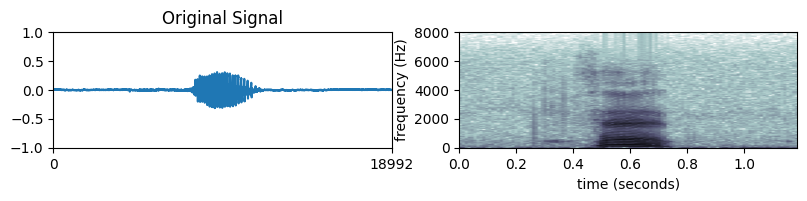

In [25]:
speechfile = addpath(apath2[3], 'kdigits0-3.wav')
speech, Fs = librosa.load(speechfile, sr=None, mono=True)

plt.figure(figsize=FIG_SIZE*np.array([1.2,0.5]))
plt.subplot(1,2,1)
plt.plot(speech); plt.xlim(0,len(speech)); plt.ylim(-1,1); plt.xticks([0, len(speech)])
plt.title('Original Signal')
plt.subplot(1,2,2)
drawspectrogram3(speech, Fs, NFFT, Ns, minpercentile=1, isdbscale=True, isdraw=True, colormap=cmap_plot)

In [26]:
# kdigits0-3.wav
IPython.display.Audio(addpath(apath2[3], 'kdigits0-3.wav'))

In [41]:
noisyroots = [addpath(audioroot,'nbnSNR'), addpath(audioroot,'wbnSNR')] # ['unsegmented-test/nbnSNR', 'unsegmented-test/wbnSNR']
SNRs = [10, 0, -10]

num_trials = 10
noisy = [nbnsig, wbnsig]
cnt = 0
path = []
path2 = []

# Open new WAV file for writing
for jj in range(len(noisy)):
    for n in range(len(noisy[jj])):
        path.append(addpath('%s%d'%(noisyroots[jj],SNRs[n]), '%s'%(labels[0])))
        for trial in range(num_trials):
            path2.append(addpath(path[n+3*jj], str(trial)))   # ex: unsegmented-test/nbnSNR10/gjang/0
            if not os.path.exists(path2[trial+10*n+30*jj]):   
                os.makedirs(path2[trial+10*n+30*jj])

for subname in labels:
    num_files = 0
    for w in range(10):
        for trial in range(10):
            basename = '%d/kdigits%d-%d.wav'%(w,trial,w)
            infile = addpath(audioclean, addpath(subname, basename))
            num_files += 1
            
            signal, Fs = librosa.load(infile, sr=Fs, mono=True)
            nbnsig = generate_mixed_signals_2(signal, np.concatenate((noise,noise,noise)), SNRs, False)
            wbnsig = generate_mixed_signals_2(signal, np.concatenate((wnoise,wnoise,wnoise)), SNRs, False)
            noisy = [nbnsig, wbnsig]

            for jj in range(len(noisy)):
                for n in range(len(noisy[jj])):
                    outfile = addpath('%s%d'%(noisyroots[jj],SNRs[n]), addpath(subname, basename))
                    wav.writewav(outfile, Fs, noisy[jj][n], maxval=1.0)
outputpaths = []
for jj in range(len(noisy)):
    for n in range(len(noisy[jj])):
        outputpaths.append('%s%d'%(noisyroots[jj],SNRs[n]))

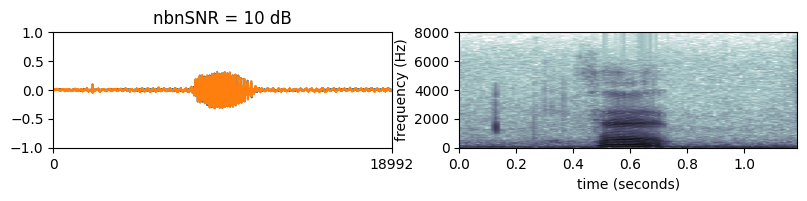

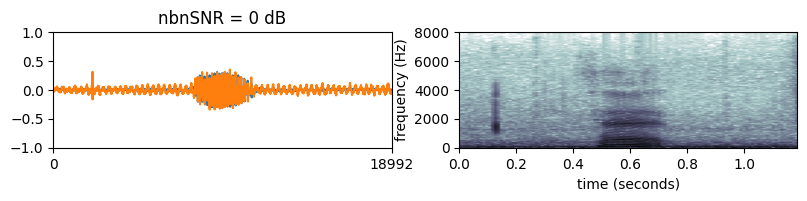

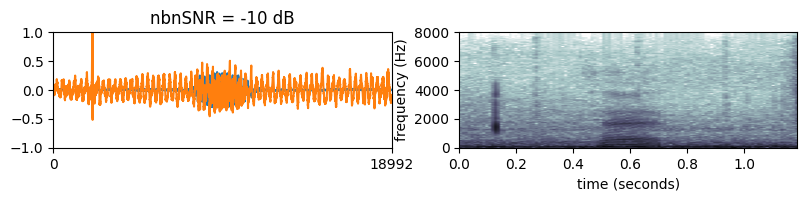

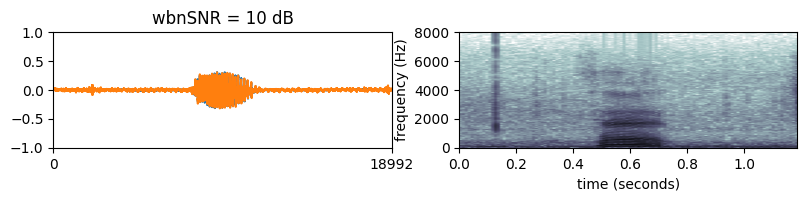

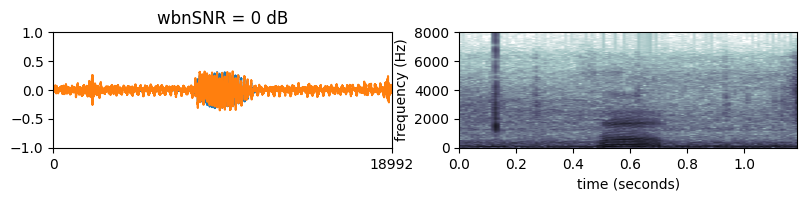

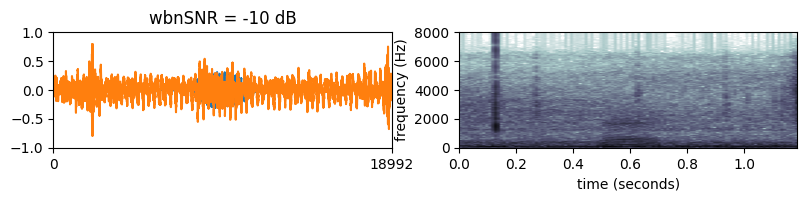

In [42]:
for i in range(len(path)):
    if i<3:
        speech_noise, Fs_noise = librosa.load(addpath(path2[i*10+3], 'kdigits0-3.wav'), sr=None, mono=True)
        plt.figure(figsize=FIG_SIZE*np.array([1.2,0.5]))
        plt.subplot(1,2,1)
        plt.plot(speech); plt.plot(speech_noise); plt.xlim(0,len(speech)); plt.ylim(-1,1); plt.xticks([0, len(speech)])
        plt.title('nbnSNR = %d dB' % (SNRs[i]))
        plt.subplot(1,2,2)
        drawspectrogram3(speech_noise, Fs, NFFT, Ns, minpercentile=1, colormap=cmap_plot)
    else:
        speech_noise, Fs_noise = librosa.load(addpath(path2[i*10+3], 'kdigits0-3.wav'), sr=None, mono=True)
        plt.figure(figsize=FIG_SIZE*np.array([1.2,0.5]))
        plt.subplot(1,2,1)
        plt.plot(speech); plt.plot(speech_noise); plt.xlim(0,len(speech)); plt.ylim(-1,1); plt.xticks([0, len(speech)])
        plt.title('wbnSNR = %d dB' % (SNRs[i-3]))
        plt.subplot(1,2,2)
        drawspectrogram3(speech_noise, Fs, NFFT, Ns, minpercentile=1, colormap=cmap_plot)

In [29]:
# nbnSNR 10dB에서의 kdigits0-3.wav
IPython.display.Audio(addpath(path2[3], 'kdigits0-3.wav'))

In [30]:
# nbnSNR 0dB에서의 kdigits0-3.wav
IPython.display.Audio(addpath(path2[13], 'kdigits0-3.wav'))

In [31]:
# nbnSNR -10dB에서의 kdigits0-3.wav
IPython.display.Audio(addpath(path2[23], 'kdigits0-3.wav'))

In [32]:
# wbnSNR 10dB에서의 kdigits0-3.wav
IPython.display.Audio(addpath(path2[33], 'kdigits0-3.wav'))

In [33]:
# wbnSNR 0dB에서의 kdigits0-3.wav
IPython.display.Audio(addpath(path2[43], 'kdigits0-3.wav'))

In [34]:
# wbnSNR -10dB에서의 kdigits0-3.wav
IPython.display.Audio(addpath(path2[53], 'kdigits0-3.wav'))

## noise된 test set의 HMM test

In [43]:
for outpath in outputpaths:
    print('---------------------------------------------------------------------------------------------')
    print('testing', outpath)
    validation_digits(speechmodels, gmmhmmindexdict, outpath, labels, 'kdigits', num_trials=10)

---------------------------------------------------------------------------------------------
testing unsegmented-test/nbnSNR10
---------------------------------------------------------------------------------------------
file name: unsegmented-test/nbnSNR10/gjang/0/kdigits0-0.wav || Trial num: 0 || MFCC shape:  (124, 6)
file name: unsegmented-test/nbnSNR10/gjang/0/kdigits1-0.wav || Trial num: 0 || MFCC shape:  (123, 6)
file name: unsegmented-test/nbnSNR10/gjang/0/kdigits2-0.wav || Trial num: 0 || MFCC shape:  (122, 6)
file name: unsegmented-test/nbnSNR10/gjang/0/kdigits3-0.wav || Trial num: 0 || MFCC shape:  (122, 6)
file name: unsegmented-test/nbnSNR10/gjang/0/kdigits4-0.wav || Trial num: 0 || MFCC shape:  (121, 6)
file name: unsegmented-test/nbnSNR10/gjang/0/kdigits5-0.wav || Trial num: 0 || MFCC shape:  (122, 6)
file name: unsegmented-test/nbnSNR10/gjang/0/kdigits6-0.wav || Trial num: 0 || MFCC shape:  (122, 6)
file name: unsegmented-test/nbnSNR10/gjang/0/kdigits7-0.wav || Trial nu

file name: unsegmented-test/wbnSNR10/gjang/1/kdigits5-1.wav || Trial num: 1 || MFCC shape:  (125, 6)
file name: unsegmented-test/wbnSNR10/gjang/1/kdigits6-1.wav || Trial num: 1 || MFCC shape:  (127, 6)
file name: unsegmented-test/wbnSNR10/gjang/1/kdigits7-1.wav || Trial num: 1 || MFCC shape:  (127, 6)
file name: unsegmented-test/wbnSNR10/gjang/1/kdigits8-1.wav || Trial num: 1 || MFCC shape:  (128, 6)
file name: unsegmented-test/wbnSNR10/gjang/1/kdigits9-1.wav || Trial num: 1 || MFCC shape:  (130, 6)
...

---------------------------------------------------------------------------------------------
Words spoken: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
[validation] number of labels and features = 100, 100
Loading data completed
Prediction started

Prediction for Testing DataSet: unsegmented-test/wbnSNR10

accuracy =10.0

---------------------------------------------------------------------------------------------
testing unsegmented-test/wbnSNR0
--------------------------------

# Wiener filtering을 통한 noise 제거

In [76]:
import scipy.io.wavfile as wav
import numpy as np

def wiener_filter(signal, noise, alpha=0.5):

    signal_fft = np.fft.fft(signal)
    noise_fft = np.fft.fft(noise)
    
    signal_power = np.abs(signal_fft) ** 2
    noise_power = np.abs(noise_fft) ** 2
    
    transfer_function = 1 - alpha * (noise_power / signal_power)
    transfer_function = np.maximum(transfer_function, 0)
    
    filtered_signal_fft = transfer_function * signal_fft
    filtered_signal = np.real(np.fft.ifft(filtered_signal_fft))
    
    return filtered_signal


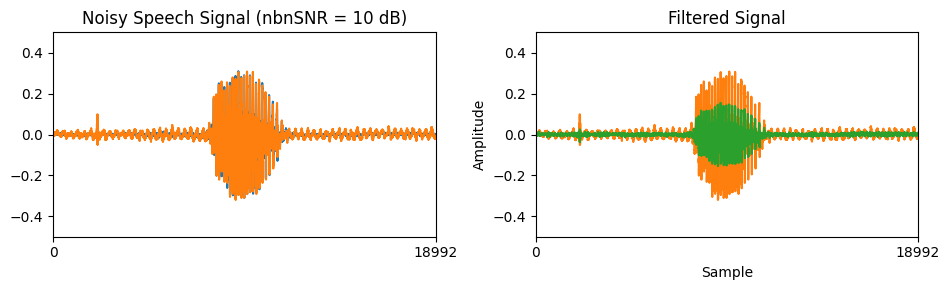

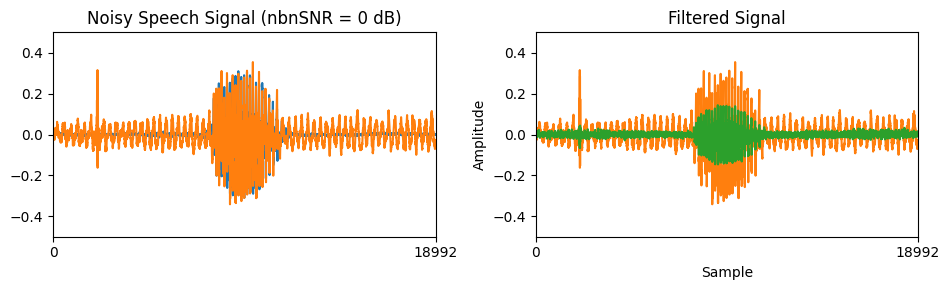

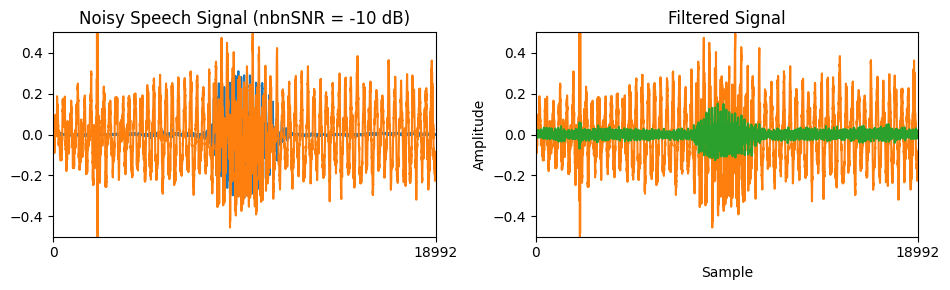

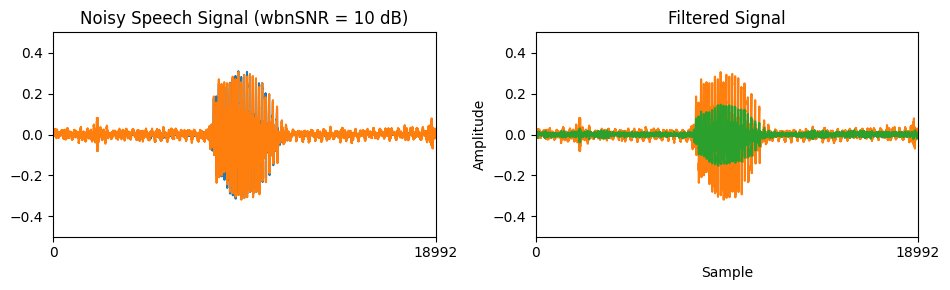

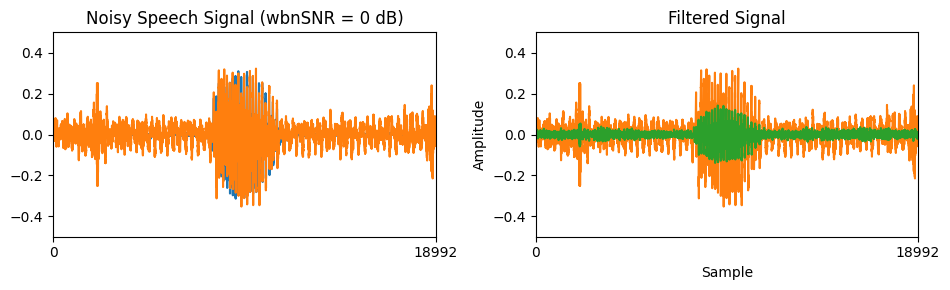

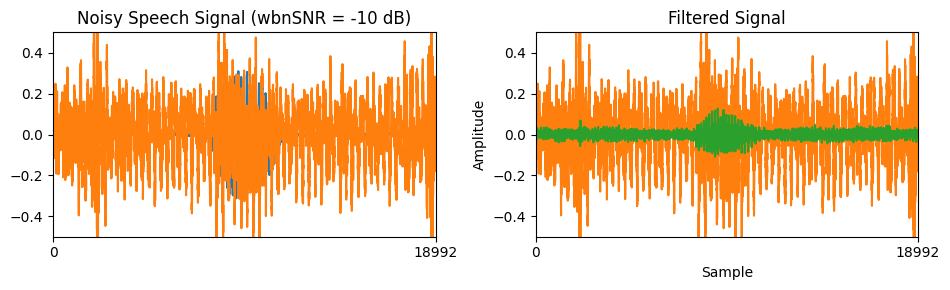

In [92]:
import wave

path_filter = addpath(audioroot, 'Wiener Filtering')
if not os.path.exists(path_filter):
    os.makedirs(path_filter)

filtered_wavfiles = []
for i in range(len(path)):
    speech_noise, Fs_noise = librosa.load(addpath(path2[i*10+3], 'kdigits0-3.wav'), sr=None, mono=True)
    #Fs_noise, speech_noise = wav.read(addpath(path2[i*10+3], 'kdigits0-3.wav'))

    # Apply a Wiener filter to the audio signal
    filtered_data = wiener_filter(speech, speech_noise)
    if i<3:
        plt.figure(figsize=FIG_SIZE*np.array([1.2,1]))
        plt.subplot(1,2,1)
        plt.title('Noisy Speech Signal (nbnSNR = %d dB)' % (SNRs[i]))
        plt.plot(speech); plt.plot(speech_noise); plt.xlim(0,len(speech)); plt.ylim(-0.5,0.5); plt.xticks([0, len(speech)])
        plt.subplot(1,2,2)
        plt.plot(speech_noise, color='#ff7f0e'); plt.plot(filtered_data, color='#2ca02c'); plt.xlim(0,len(speech)); plt.ylim(-0.5,0.5); plt.xticks([0, len(speech)])
        plt.title('Filtered Signal')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.tight_layout()
        plt.show()
        
        # Save the filtered signal to a new WAV file
        #outfile = addpath(path_filter, "{}{}-{}_{}{}.wav".format(tag,0,3,'nbnSNR',SNRs[i]))
        #wav.writewav(outfile, Fs_noise, filtered_data)        
        
    else:
        plt.figure(figsize=FIG_SIZE*np.array([1.2,1]))
        plt.subplot(1,2,1)
        plt.title('Noisy Speech Signal (wbnSNR = %d dB)' % (SNRs[i-3]))
        plt.plot(speech); plt.plot(speech_noise); plt.xlim(0,len(speech)); plt.ylim(-0.5,0.5); plt.xticks([0, len(speech)])
        plt.subplot(1,2,2)
        plt.plot(speech_noise, color='#ff7f0e'); plt.plot(filtered_data, color='#2ca02c'); plt.xlim(0,len(speech)); plt.ylim(-0.5,0.5); plt.xticks([0, len(speech)])
        plt.title('Filtered Signal')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.tight_layout()
        plt.show()

        # Save the filtered signal to a new WAV file
        #outfile = addpath(path_filter, "{}{}-{}_{}{}.wav".format(tag,0,3,'wbnSNR',SNRs[i-3]))
        #wav.writewav(outfile, Fs_noise, filtered_data)          

In [82]:
# Wiener filtering된 nbnSNR 10dB에서의 kdigits0-3.wav
IPython.display.Audio(addpath(path_filter, "kdigits0-3_nbnSNR10.wav"))

In [83]:
# Wiener filtering된 nbnSNR 0dB에서의 kdigits0-3.wav
IPython.display.Audio(addpath(path_filter, "kdigits0-3_nbnSNR0.wav"))

In [84]:
# Wiener filtering된 nbnSNR -10dB에서의 kdigits0-3.wav
IPython.display.Audio(addpath(path_filter, "kdigits0-3_nbnSNR-10.wav"))

In [85]:
# Wiener filtering된 wbnSNR 10dB에서의 kdigits0-3.wav
IPython.display.Audio(addpath(path_filter, "kdigits0-3_wbnSNR10.wav"))

In [86]:
# Wiener filtering된 wbnSNR 0dB에서의 kdigits0-3.wav
IPython.display.Audio(addpath(path_filter, "kdigits0-3_wbnSNR0.wav"))

In [87]:
# Wiener filtering된 wbnSNR -10dB에서의 kdigits0-3.wav
IPython.display.Audio(addpath(path_filter, "kdigits0-3_wbnSNR-10.wav"))

## End of Project 1